I: Develop and explore the various python API's for downloading crypto prices, and see which one's are best. 

Question to consider include 

- time resolution

- realtime updates? 

- additional info aside from price?

- missing data? 


Starting with PyCoinGecko

In [7]:
from pycoingecko import CoinGeckoAPI
cg = CoinGeckoAPI()

In [8]:
cg.get_price(ids='bitcoin', vs_currencies='usd')


{'bitcoin': {'usd': 61509}}

In [9]:
cg.ping()

{'gecko_says': '(V3) To the Moon!'}

In [10]:
cg.get_price()

TypeError: get_price() missing 2 required positional arguments: 'ids' and 'vs_currencies'

In [15]:
cg.get_coin_market_chart_range_by_id(id='bitcoin',vs_currency='usd',from_timestamp= 1449071860,to_timestamp=1549071865)

{'prices': [[1449100800000, 360.954],
  [1449187200000, 362.7669999999999],
  [1449273600000, 390.645],
  [1449360000000, 394.0109999999999],
  [1449446400000, 394.355],
  [1449532800000, 412.9300000000001],
  [1449619200000, 417.3679999999999],
  [1449705600000, 416.91],
  [1449792000000, 452.4149999999999],
  [1449878400000, 434.903],
  [1449964800000, 435.8150000000001],
  [1450051200000, 443.277],
  [1450137600000, 464.9989999999999],
  [1450224000000, 453.9139999999999],
  [1450310400000, 456.473],
  [1450396800000, 463.816],
  [1450483200000, 462.0529999999999],
  [1450569600000, 441.1289999999999],
  [1450656000000, 437.8090000000001],
  [1450742400000, 436.2370000000001],
  [1450828800000, 442.821],
  [1450915200000, 454.907],
  [1451001600000, 455.7419999999999],
  [1451088000000, 417.092],
  [1451174400000, 423.925],
  [1451260800000, 420.708],
  [1451347200000, 432.1540000000001],
  [1451433600000, 426.811],
  [1451520000000, 431.139],
  [1451606400000, 434.4269999999999],
 

This looks useful, the important change now is 1) what the heck is a timestamp, and 2) can this be massaged into better formats. 

In [20]:
from datetime import datetime

timestamp = 1449100800000 // 1000
dt_object = datetime.fromtimestamp(timestamp)

print("dt_object =", dt_object)
print("type(dt_object) =", type(dt_object))




# this is in agreement with the historical price shown after looking it up. Can confirm. 

dt_object = 2015-12-02 19:00:00
type(dt_object) = <class 'datetime.datetime'>


In [26]:
from datetime import datetime

timestamp = 1449187200000 // 1000
dt_object = datetime.fromtimestamp(timestamp)

print("dt_object =", dt_object)
print("type(dt_object) =", type(dt_object))




dt_object = 2015-12-03 19:00:00
type(dt_object) = <class 'datetime.datetime'>


In [21]:
# resolution? 

# appears to be a day

In [24]:
timedelta = (1449187200000 - 1449100800000) // 1000

In [25]:
timedelta

86400

In [29]:
86400 / (24 * 60 * 60) # each unit is a second, and delta is 1 days worth of seconds. 

1.0

So we have a bit of an idea, now let's find the most recent day, and go back 5 years to collect data. 

In [39]:
# most recent update of this coin occured at 

today = cg.get_price(ids='bitcoin', vs_currencies='usd',include_last_updated_at=True)['bitcoin']['last_updated_at']

In [40]:
start = int(today - 1.577e8) # subtract 5 years 


In [47]:
btc_history = cg.get_coin_market_chart_range_by_id(id='bitcoin',vs_currency='usd',include_market_cap='true',from_timestamp= start,to_timestamp=today)



In [48]:
btc_history.keys()

dict_keys(['prices', 'market_caps', 'total_volumes'])

In [64]:
import numpy as np

In [65]:
# now save dict as dataframe?  

prices = np.array(btc_history['prices'])

In [67]:
dates = prices[:,0]
price = prices[:,1]

In [68]:
price

array([  706.0925    ,   708.94      ,   721.1775    , ...,
       63247.20896128, 63130.94235172, 61601.74357205])

In [70]:
dates = [datetime.fromtimestamp(timestamp // 1000) for timestamp in dates]

In [72]:
import pandas as pd

In [73]:
btc_df = pd.DataFrame()
btc_df['date'] = dates
btc_df['price'] = price

In [75]:
btc_df.head()

,date,price
0,2016-11-06 19:00:00,706.092500
1,2016-11-07 19:00:00,708.940000
2,2016-11-08 19:00:00,721.177500
3,2016-11-09 19:00:00,713.214143
4,2016-11-10 19:00:00,715.642500


Nice! That's basically the rough format we'd want to see. A lot of the code above can be stored in some util class 

In [76]:
# now some basic visuals. 

In [77]:
import matplotlib.pyplot as plt
%matplotlib inline

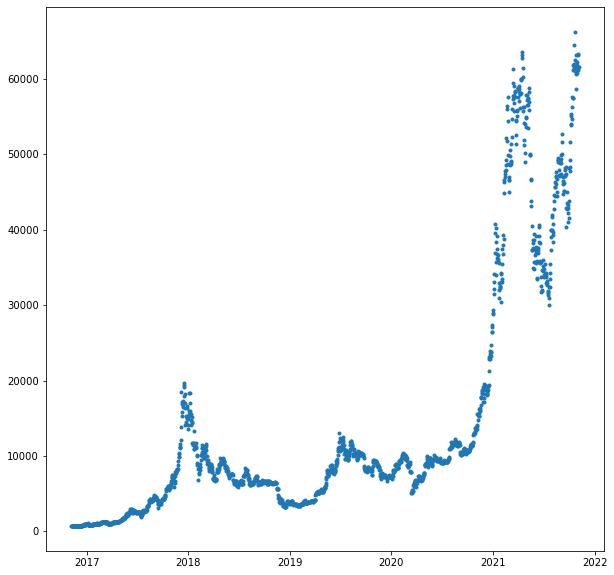

In [80]:
plt.figure(figsize = (10,10))
plt.plot(btc_df['date'],btc_df['price'], '.')

Based on this I do feel like there are days which are significant bursts up or down compared to the usual long term patterns. If we observe the trend of BTC in the leading up to days or months, can we predict whether the next short period, say a week, is going to portend to positive, negative, or neutral gains? 

I'll try to answer how to prepare this data in the next notebook, for now we can effectively wrap what was developed here into some sort of "grab data" script to use next. 

In [8]:
from datetime import datetime
from pycoingecko import CoinGeckoAPI

import numpy as np
import pandas as pd

def collect_data(prior_years, crypto, values):
    """
    Collects data from the CoinGeck Object from the current timestamp and rolls back the designated # of years to find
    historical data, packaging it all in a pandas dataframe. 
    
    Params:
    prior_years
        5
    crypto
        btc
    values
        usd
    """
    
    cg = CoinGeckoAPI()
    
    today = cg.get_price(ids='bitcoin', vs_currencies='usd',include_last_updated_at=True)['bitcoin']['last_updated_at']
    start = int(today - prior_years*31536000) # subtract prior years 

    
    btc_history = cg.get_coin_market_chart_range_by_id(id=crypto,vs_currency=values,include_market_cap='true',from_timestamp= start,to_timestamp=today)
    prices = np.array(btc_history['prices'])
    timestamps = prices[:,0]
    price = prices[:,1]
    dates = [datetime.fromtimestamp(timestamp // 1000) for timestamp in timestamps]
    cg_df = pd.DataFrame()
    cg_df['timestamp'] = timestamps
    cg_df['date'] = dates
    cg_df[crypto + '_price'] = price
    
    return cg_df

# TODO: finish this function, save, and use for fuller data discover in proceeding notebook. 

In [9]:
cg_df = collect_data(prior_years=1,crypto='bitcoin',values='usd')

In [10]:
cg_df

,timestamp,date,bitcoin_price
0,1.604621e+12,2020-11-05 19:00:00,15553.331701
1,1.604707e+12,2020-11-06 19:00:00,15548.312145
2,1.604794e+12,2020-11-07 19:00:00,14818.458911
3,1.604880e+12,2020-11-08 19:00:00,15496.316149
4,1.604966e+12,2020-11-09 19:00:00,15335.342198
...,...,...,...
360,1.635725e+12,2021-10-31 20:00:00,61471.868463
361,1.635811e+12,2021-11-01 20:00:00,61121.831201
362,1.635898e+12,2021-11-02 20:00:00,63247.208961
363,1.635984e+12,2021-11-03 20:00:00,63130.942352
